###### EXPLICAÇÃO SOBRE O FUNCIONAMENTO DO MÉTODO

In [1]:
%matplotlib inline
from matplotlib import pyplot
import sys
import numpy
import cv2

In [2]:
#Abrindo a imagem
nomeDaImagemDeEntrada = 'unequal.png'
img = cv2.imread(nomeDaImagemDeEntrada,0)
#Nome do arquivo de saída que receberá a imagem comprimida
nomeDaImagemDeSaida = "LenaBinario"

#Formato da Imagem
dimensaoDaImagem = img.shape

#Tamanho da máscara. No nosso algoritmo, sempre será 8x8
#Esse valor ao quadrado deve ser divisível por 8!!!!!!
tamanhoDoQuadrado = 8

--------------------------------------------------------FUNÇÕES DE CODIFICAÇÃO--------------------------------------------------------

In [3]:
#----------------------------------------------------------------------------------------------
#Retorna o valor do menor pixel (8 bits)
'''
Exemplo: seja a matriz abaixo passada como parametro

[[128, 128, 128]
 [1  , 1  , 1]
 [3  , 3  , 3]]
 
a função menorPixel() retornará o pixel de valor 1
'''
def menorPixel(quadrado):
    pixel = 256
    for i in range(0, tamanhoDoQuadrado):
        for j in range(0, tamanhoDoQuadrado):
            if(pixel > quadrado[i][j]):
                pixel = quadrado[i][j]
    return pixel
'''----------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////
----------------------------------------------------------------------------------------------'''
#Retorna o valor mínimo de bits por pixel para armazenar todas as diferenças sem perder
# informação.
#Deve ser passado, como parâmetro, o quadrado 8x8 já com subtração efetuada. Isto é, o método
# não realiza a subtração no quadrado.
def calcularMinimoDeBitsPorPixel(quadrado):
    maior = 0
    for i in range(0,tamanhoDoQuadrado):
        for j in range(0,tamanhoDoQuadrado):
            if(maior < quadrado[i][j]):
                maior = quadrado[i][j]
                
    if(maior == 0):
        return 1
    return numpy.floor(numpy.log2(maior)) + 1

'''----------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////
----------------------------------------------------------------------------------------------'''
#Escreve um quadrado 8x8 na forma comprimida.
def escreverQuadradoEmBits(quadrado, menorPixel, bitsPorPixel, nomeArquivo):
    shiftQuantidadeDeBitsPorPixels = 8
    file = open(nomeArquivo, 'ab')
    
    #-----------------------------------------------------------------------------------------
    #CONVERSÕES PARA TIPO NATIVO PYTHON
    
    #-----------------------------------------------------------------------------------------
    menorPixel = int(menorPixel)
    bitsPorPixel = int(bitsPorPixel)
    #-----------------------------------------------------------------------------------------
    #CABEÇALHO DO QUADRADO
    #8 bits pro menor pixel - 8 bits com o tamanho em bits dos 8 pixels seguintes
    bits = menorPixel
    
    #Nenhuma diferença de pixels será maior que um número que possa ser representado com 4 bits, 
    #tendo em vista que a imagem possui 8 bits/pixel. Mas, para facilitar a leitura, usaremos 1 byte
    #para armazenar o número de bits/pixel.
    bits = bits << shiftQuantidadeDeBitsPorPixels
    bits = bits | bitsPorPixel
    file.write((int(bits)).to_bytes(2, byteorder='big'))
    #-----------------------------------------------------------------------------------------
    
    #-----------------------------------------------------------------------------------------
    #64 pixels escritos como a diferença entre eles e o menor pixel
    contador = 0
    bits = int(0x0)
    for i in range(0, tamanhoDoQuadrado):
        for j in range(0, tamanhoDoQuadrado):
            contador += 1
            bits = bits << bitsPorPixel
            bits = bits | int(quadrado[i][j])
            if(contador == 8):
                contador = 0
                file.write((int(bits)).to_bytes(bitsPorPixel, byteorder='big'))
                bits = int(0x0)
    file.close()
    
    return int(bitsPorPixel) * tamanhoDoQuadrado * tamanhoDoQuadrado
    
'''----------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////
----------------------------------------------------------------------------------------------'''
#Ajustando a dimensão da imagem
def corrigeDimensoes(imagem):
    dimensoes = imagem.shape
    
    linhasAMais = dimensoes[0]%tamanhoDoQuadrado
    if(linhasAMais != 0):
        for i in range(0, tamanhoDoQuadrado-linhasAMais):
            imagem = numpy.concatenate( (imagem, numpy.array([ imagem[imagem.shape[0]-1, 0:imagem.shape[1]] ]) ), axis=0 )
            
    colunasAMais = dimensoes[1]%tamanhoDoQuadrado
    if(colunasAMais != 0):
        for i in range(0, tamanhoDoQuadrado-colunasAMais):
            imagem = numpy.concatenate( (imagem, numpy.array([ imagem[0:imagem.shape[0], imagem.shape[1]-1] ]).transpose() ), axis=1 )
    return imagem

--------------------------------------------------------FUNÇÃO MAIN--------------------------------------------------------

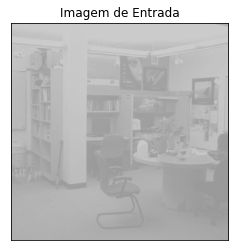

(400, 400)

In [4]:
#Exibindo a imagem original
pyplot.subplot(111),pyplot.imshow(img, cmap = 'gray', clim=(0, 255))
pyplot.title("Imagem de Entrada"), pyplot.xticks([]), pyplot.yticks([])
pyplot.show()
img.shape

In [5]:
#Gravando o cabeçalho inicial
#Dimensão da imagem (linhas e colunas) com 4 bytes para cada um dos dois
#-------------------------------------------
############################################
#-------------------------------------------
f = open(nomeDaImagemDeSaida, 'wb')
f.write( (int(img.shape[0])).to_bytes(4, byteorder='big') )
f.write( (int(img.shape[1])).to_bytes(4, byteorder='big') )
f.close()

In [6]:
#Ajustando as dimensões da imagem para ela ser divisível por 8
img = corrigeDimensoes(img)

In [7]:
#Codificando a imagem e armazenando ela no arquivo em binário
quadradosEscritos = 0
bitsPorPixelTotal = 0
quantidadeDePixelsTotal = img.shape[0]*img.shape[1]
for i in range(0, dimensaoDaImagem[0], tamanhoDoQuadrado):
    for j in range(0, dimensaoDaImagem[1], tamanhoDoQuadrado):
        quadradosEscritos += 1
        #Obtendo o menor pixel no quadrado 8x8
        mPixel = menorPixel(img[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado])
        
        #Subtraindo o menor pixel da matriz
        img[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado] = img[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado] - mPixel
        
        #Calculando a quantidade mínima de bits por pixel no bloco 8x8 atual
        mBitsPorPixel = calcularMinimoDeBitsPorPixel(img[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado])
        
        #Salvando o valor no arquivo binário
        bitsPorPixelTotal += escreverQuadradoEmBits(img[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado], mPixel, mBitsPorPixel, nomeDaImagemDeSaida)

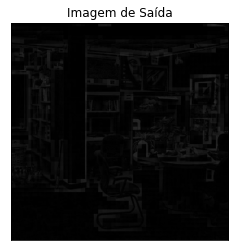

In [8]:
#Esta é a matriz após, de cada submatriz 8x8 da imagem ser subtraído o menor valor de pixel da submatriz
pyplot.subplot(111),pyplot.imshow(img, cmap = 'gray', clim=(0, 255))
pyplot.title("Imagem de Saída"), pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

--------------------------------------------------------DECODIFICAÇÃO----------------------------------------------------------

--------------------------------------------------------FUNÇÕES DE DECODIFICAÇÃO--------------------------------------------------------

In [9]:
def leBloco(file):
    dadosBloco = [0, 0, 0x0]
    dadosBloco[0] = int.from_bytes(file.read(1), byteorder='big')
    dadosBloco[1] = int.from_bytes(file.read(1), byteorder='big')
    bytesASeremLidos = int(((tamanhoDoQuadrado*tamanhoDoQuadrado)*dadosBloco[1])/8)
    dadosBloco[2] = file.read(bytesASeremLidos)
    return dadosBloco

def bitsToInt(bitsPorPixel, stringDeBits):
    subMatrizDaImagem = numpy.zeros((tamanhoDoQuadrado, tamanhoDoQuadrado), dtype=int)
    stringDeBits = int.from_bytes(stringDeBits, byteorder='big')

    mascara = 0x1
    for i in range(0, int(bitsPorPixel)-1):
        mascara = mascara << 1
        mascara = mascara | 0x1
    for i in range(tamanhoDoQuadrado-1, -1, -1):
        for j in range(tamanhoDoQuadrado-1, -1, -1):
            subMatrizDaImagem[i][j] += int(stringDeBits & mascara)
            stringDeBits = stringDeBits >> int(bitsPorPixel)
    return subMatrizDaImagem

--------------------------------------------------------FUNÇÃO MAIN--------------------------------------------------------

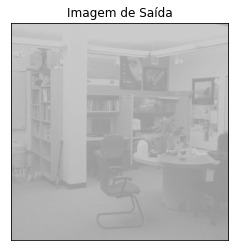

In [10]:
f = open(nomeDaImagemDeSaida, 'rb')
linhas  = int.from_bytes(f.read(4), byteorder='big') #largura da imagem
colunas = int.from_bytes(f.read(4), byteorder='big') #altura da imagem

reconstruida = numpy.zeros((linhas, colunas), dtype=int)
reconstruida = corrigeDimensoes(reconstruida)
for i in range(0, dimensaoDaImagem[0], tamanhoDoQuadrado):
    for j in range(0, dimensaoDaImagem[1], tamanhoDoQuadrado):
        dadosBloco = leBloco(f)
        blocoAtual = numpy.array(bitsToInt(dadosBloco[1], dadosBloco[2])+dadosBloco[0])
        reconstruida[i:i+tamanhoDoQuadrado, j:j+tamanhoDoQuadrado] = blocoAtual
        
reconstruida = reconstruida[0:linhas, 0:colunas]
pyplot.subplot(111),pyplot.imshow(reconstruida, cmap = 'gray', clim=(0, 255))
pyplot.title("Imagem de Saída"), pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

--------------------------------------------------------MEDIDA DE QUALIDADE--------------------------------------------------------

--------------------------------------------------------FUNÇÕES DE MEDIDA DE QUALIDADE--------------------------------------------------------

In [11]:
def MSE(imgOriginal, imgProcessada):
    diferenca = imgOriginal - imgProcessada
    quadradoDeCadaDiferenca = diferenca ** 2
    mse = quadradoDeCadaDiferenca.mean()
    return mse

In [12]:
#O método é um método sem perdas. Ou seja, não há como calcaular o PSNR, porque o Erro Médio Quadrático é 0
img = cv2.imread(nomeDaImagemDeEntrada, 0)
print("Erro Médio Quadrático: ", MSE(img, reconstruida))
print("Taxa de Compressão(sem cabeçalho): ", (quantidadeDePixelsTotal*8)/bitsPorPixelTotal)

Erro Médio Quadrático:  0.0
Taxa de Compressão(sem cabeçalho):  2.3432923257176332
